# Formatting Weather Data

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_weather = pd.read_csv('county_level_weather.csv')
df_weather.head()

,Unnamed: 0,County,Var,Year,January,February,March,April,May,June,July,August,September,October,November,December
0,0,Sierra,ppt,1980,415.709686,382.501617,111.128197,79.320557,64.565422,22.852375,17.899927,5.491146,9.450271,33.582626,41.988926,120.442238
1,1,Sierra,ppt,1981,236.459885,113.850082,176.456726,44.330055,63.482513,3.611892,0.004392,0.003986,30.670328,174.779312,504.357941,377.453613
2,2,Sierra,ppt,1982,229.290253,221.140564,298.874725,318.278595,11.199191,37.534851,13.221622,5.106486,111.741684,202.075043,250.340317,253.627685
3,3,Sierra,ppt,1983,232.798508,369.659393,429.405151,169.349167,41.239933,30.229248,8.763040,30.967905,54.934071,91.135620,504.704224,429.239380
4,4,Sierra,ppt,1984,17.905682,185.402206,118.662277,81.836754,31.953772,41.990131,17.944529,9.015877,8.106352,103.931931,325.303803,62.782768


**Currently the data is quite hard to query because you have to query the Var column and then select each month. It would be a little easier if we had a column for ppt in January or VPDmax in March.**

In [0]:
#Plan: Make a bunch of series and then concat them all into a df

#List the months and variables
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
variables = df_weather['Var'].unique()

#List to store all the dfs
df_list = []

#Iterate through months
for month in months:
  
  #Filter to month
  df_month = df_weather[['County', 'Year','Var', month]]
  
  #Iterate through vars
  for var in variables:
    
    #Name column
    desired_name = month+ '_' + var
   
    #Filter to variables
    df_month_var = df_month.loc[df_month['Var'] == var].rename(columns = {month:month+ '_' + var}).drop(['Var'], axis = 1)
    
    #Append to list
    df_list.append(df_month_var)


**We have a list of all of our dfs. We now want to merge them on county and year. We can use [reduce()](https://book.pythontips.com/en/latest/map_filter.html) from functools to do a "rolling" computation.**

In [0]:
from functools import reduce
df_weather_merged = reduce(lambda  left,right: pd.merge(left,right,on=['County', 'Year'],
                                            how='outer'), df_list)

**Check out the result. This will be much easier to query!**

In [5]:
df_weather_merged.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,July_tmin,July_tmean,July_vpdmax,July_vpdmin,August_ppt,August_tmax,August_tmin,August_tmean,August_vpdmax,August_vpdmin,September_ppt,September_tmax,September_tmin,September_tmean,September_vpdmax,September_vpdmin,October_ppt,October_tmax,October_tmin,October_tmean,October_vpdmax,October_vpdmin,November_ppt,November_tmax,November_tmin,November_tmean,November_vpdmax,November_vpdmin,December_ppt,December_tmax,December_tmin,December_tmean,December_vpdmax,December_vpdmin
0,Sierra,1980,415.709686,6.415811,-3.536688,1.439561,4.567096,0.900473,382.501617,8.022836,-2.534324,2.744257,5.629257,0.789730,111.128197,7.917772,-5.233783,1.341993,6.811284,0.682297,79.320557,13.614462,-1.097838,6.258314,10.897299,1.161824,64.565422,15.683310,0.992230,8.337770,11.865405,0.895135,22.852375,19.245747,3.274729,11.260235,17.064259,1.857500,17.899927,26.238316,8.823446,17.530876,27.083784,3.966961,5.491146,26.291409,7.511015,16.901215,26.967834,4.109053,9.450271,23.308172,5.381148,14.344664,22.066820,3.330068,33.582626,19.002371,2.778716,10.890538,18.790813,3.336960,41.988926,12.337703,-1.470270,5.433717,10.158244,1.870744,120.442238,9.734934,-2.962905,3.386014,7.433448,1.787973
1,Sierra,1981,236.459885,8.395609,-2.993514,2.701048,6.016489,1.165946,113.850082,8.561417,-4.455543,2.052938,6.531755,0.810541,176.456726,8.589664,-3.696690,2.446487,6.609324,0.625608,44.330055,15.086349,-0.506689,7.289832,12.669528,1.405135,63.482513,17.870880,2.478244,10.174561,14.247837,1.583581,3.611892,25.063646,7.333107,16.198380,26.455404,4.156149,0.004392,28.257565,7.969191,18.113373,30.818111,5.258446,0.003986,29.495882,9.242567,19.369221,34.532028,5.360677,30.670328,25.396759,5.445946,15.421350,26.011009,3.415271,174.779312,14.616889,-0.292500,7.162194,11.256150,1.253851,504.357941,9.719727,-0.623716,4.548007,6.220675,1.111013,377.453613,7.190676,-2.197568,2.496554,4.770134,0.884527
2,Sierra,1982,229.290253,3.619055,-7.895067,-2.138007,4.508716,0.764730,221.140564,7.794862,-4.801757,1.496554,5.964256,0.856622,298.874725,5.931688,-4.472634,0.729527,4.644662,0.493378,318.278595,9.859526,-3.423514,3.218006,8.250746,0.886622,11.199191,19.200678,2.442703,10.821689,16.439463,1.980878,37.534851,20.913446,4.078379,12.495912,16.954527,1.311554,13.221622,25.221491,7.598379,16.409931,23.902836,3.263716,5.106486,26.666210,8.076621,17.371418,25.862032,3.914392,111.741684,20.428988,4.299663,12.364326,17.916489,2.294729,202.075043,14.318782,0.560473,7.439631,10.204461,1.237770,250.340317,7.082770,-3.927905,1.577433,5.511013,0.724324,253.627685,4.673042,-6.284797,-0.805878,4.395406,0.615068
3,Sierra,1983,232.798508,7.183243,-4.538581,1.322331,5.768040,1.109189,369.659393,6.143716,-4.080744,1.031487,4.689865,0.672567,429.405151,5.728377,-3.414798,1.156790,3.593446,0.883919,169.349167,8.240340,-3.730946,2.254696,6.202703,0.910338,41.239933,17.409866,0.840338,9.125099,15.240196,2.710608,30.229248,21.372906,4.908716,13.140814,17.596886,2.231351,8.763040,23.608381,5.796889,14.702637,22.666622,2.862297,30.967905,25.138783,8.469391,16.804085,22.499729,2.858041,54.934071,23.404596,6.214055,14.809326,22.009392,2.949595,91.135620,17.815269,2.856553,10.335910,12.967708,1.684392,504.704224,6.938378,-2.210204,2.364088,4.500947,0.763649,429.239380,4.178243,-3.234460,0.471892,3.131824,0.621014
4,Sierra,1984,17.905682,8.866152,-4.531350,2.167399,7.160810,1.510743,185.402206,8.097907,-5.463446,1.317230,6.747838,1.062432,118.662277,12.030677,-2.222230,4.904224,8.955407,1.446283,81.836754,11.395063,-3.061217,4.166926,9.403650,1.212905,31.9537

# Yield Data

**Crop Selection**

**Load in yield data. Inspect it.**

In [6]:
df_yield = pd.read_csv('California Crop Yields.csv')

#Filter out the non-county rows
df_counties = df_yield[df_yield['County Code'] < 900].drop('Unnamed: 0', axis = 1)

#Inspect
df_counties.head()

,Year,Commodity Code,Crop Name,County Code,County,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
0,1980,261999,ALMONDS ALL,7,Butte,31468.0,0.42,13217.0,3000.0,TONS,39651000.0
1,1980,261999,ALMONDS ALL,9,Calaveras,NaN,NaN,12.0,3600.0,TONS,43200.0
2,1980,261999,ALMONDS ALL,11,Colusa,14000.0,0.15,2100.0,2800.0,TONS,5880000.0
3,1980,261999,ALMONDS ALL,13,Contra Costa,2990.0,0.19,568.0,1440.0,TONS,818000.0
4,1980,261999,ALMONDS ALL,19,Fresno,23992.0,0.59,14200.0,3000.0,TONS,42600000.0


In [7]:
df_counties['Crop Name'].unique()

array(['ALMONDS ALL', 'GRAPES WINE', 'WALNUTS ENGLISH',
       'TOMATOES PROCESSING', 'PISTACHIOS', 'GRAPES TABLE',
       'LETTUCE HEAD', 'BERRIES STRAWBERRIES PROCESSING'], dtype=object)

# Join Yield and Weather

**Next step is to introduce the yield data which was obtained in a seperate notebook. We want to join this to the weather data on county and year.**

In [8]:
df_yield = pd.read_csv('California Crop Yields.csv')

#Filter out the non-county rows
df_counties = df_yield[df_yield['County Code'] < 900].drop('Unnamed: 0', axis = 1)

#Inspect
df_counties.head()

,Year,Commodity Code,Crop Name,County Code,County,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
0,1980,261999,ALMONDS ALL,7,Butte,31468.0,0.42,13217.0,3000.0,TONS,39651000.0
1,1980,261999,ALMONDS ALL,9,Calaveras,NaN,NaN,12.0,3600.0,TONS,43200.0
2,1980,261999,ALMONDS ALL,11,Colusa,14000.0,0.15,2100.0,2800.0,TONS,5880000.0
3,1980,261999,ALMONDS ALL,13,Contra Costa,2990.0,0.19,568.0,1440.0,TONS,818000.0
4,1980,261999,ALMONDS ALL,19,Fresno,23992.0,0.59,14200.0,3000.0,TONS,42600000.0


**Perform join.**

In [9]:
#Join on county and year fields. Use inner join b/c we want data that has BOTH
#yield and weather data
df_weather_yield = df_weather_merged.merge(df_counties, how = 'inner', on = ['County', 'Year'])

#Inspect
df_weather_yield.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,July_vpdmin,August_ppt,August_tmax,August_tmin,August_tmean,August_vpdmax,August_vpdmin,September_ppt,September_tmax,September_tmin,September_tmean,September_vpdmax,September_vpdmin,October_ppt,October_tmax,October_tmin,October_tmean,October_vpdmax,October_vpdmin,November_ppt,November_tmax,November_tmin,November_tmean,November_vpdmax,November_vpdmin,December_ppt,December_tmax,December_tmin,December_tmean,December_vpdmax,December_vpdmin,Commodity Code,Crop Name,County Code,Harvested Acres,Yield per Acre,Production,Price per Unit,Unit,Total Value
0,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,5.283423,0.0,31.901814,13.363755,22.632778,33.683151,3.687382,0.000000,29.950806,12.481747,21.216278,28.104429,2.586510,2.793892,27.311007,10.023418,18.667212,25.811546,2.178456,3.032283,20.150541,5.482752,12.816646,14.114425,1.312014,52.204903,13.482215,3.379866,8.431041,5.867652,0.580940,216299,GRAPES WINE,67,3350.0,8.00,26800.0,210.0,TONS,5628000.0
1,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,5.283423,0.0,31.901814,13.363755,22.632778,33.683151,3.687382,0.000000,29.950806,12.481747,21.216278,28.104429,2.586510,2.793892,27.311007,10.023418,18.667212,25.811546,2.178456,3.032283,20.150541,5.482752,12.816646,14.114425,1.312014,52.204903,13.482215,3.379866,8.431041,5.867652,0.580940,263999,WALNUTS ENGLISH,67,410.0,0.90,369.0,951.0,TONS,351000.0
2,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,5.283423,0.0,31.901814,13.363755,22.632778,33.683151,3.687382,0.000000,29.950806,12.481747,21.216278,28.104429,2.586510,2.793892,27.311007,10.023418,18.667212,25.811546,2.178456,3.032283,20.150541,5.482752,12.816646,14.114425,1.312014,52.204903,13.482215,3.379866,8.431041,5.867652,0.580940,378299,TOMATOES PROCESSING,67,8560.0,28.97,248000.0,48.0,TONS,11805000.0
3,Sacramento,1981,132.503296,12.433155,5.035637,8.734395,4.878793,0.624967,24.492683,16.945038,5.507786,11.226409,8.647316,0.762550,100.797523,17.332417,6.301610,11.817011,9.076510,1.053423,22.273756,23.055368,7.915167,15.485265,16.645231,1.482886,11.681477,27.654425,11.198589,19.426498,25.817116,2.826376,0.000000,34.325500,15.843218,25.084354,42.518917,5.894967,0.000000,34.755516,...,4.926377,0.0,33.399597,14.123021,23.761307,35.922150,3.411410,6.128726,30.764835,13.483758,22.124290,30.313221,2.590134,55.972904,23.656918,9.064226,16.360571,18.346979,1.604698,156.213425,18.630539,9.027248,13.828894,9.326442,1.325437,94.639305,13.234232,5.938120,9.586173,4.598120,0.765839,216299,GRAPES WINE,67,3350.0,6.99,23400.0,224.0,TONS,5242000.0

# Feature Engineering

**It is possible that cumulative precipitation is more useful than the precipitation in one month. Sum up three months of precipitation data.**

**Jan + Feb + Mar = JPM**
**Feb + Mar + Apr = FMA Precip**

**So on and so forth...**

In [0]:
#Function to add a "window" of precipitation
def precip_window(month_window):

  #Create name
  var = month_window[0][0] + month_window[1][0] + month_window[2][0]
  var_ppt = var + '_ppt'

  #Make new column
  df_weather_yield[var_ppt] = df_weather_yield[month_window[0]] + df_weather_yield[month_window[1]] + df_weather_yield[month_window[2]]


In [0]:
#List of all possible windows
windows = [['January_ppt', 'February_ppt', 'March_ppt'],
           ['February_ppt', 'March_ppt', 'April_ppt'],
           ['March_ppt', 'April_ppt', 'May_ppt'],
           ['April_ppt', 'May_ppt', 'June_ppt'],
           ['May_ppt', 'June_ppt', 'July_ppt'],
           ['June_ppt', 'July_ppt', 'August_ppt'],
           ['July_ppt', 'August_ppt', 'September_ppt'],
           ['August_ppt', 'September_ppt', 'October_ppt'],
           ['September_ppt', 'October_ppt', 'November_ppt'],
           ['October_ppt', 'November_ppt', 'December_ppt'],
           ['November_ppt', 'December_ppt', 'January_ppt'],
            ['December_ppt', 'January_ppt', 'February_ppt']]

#Use function
for window in windows:
  precip_window(window)

**In our model it will be important to consider the squares of some of our variables. We can add those columns now.**

In [0]:
#We don't want to square these!
unaltered_vars = ['Year','County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']

for column in list(df_weather_yield.columns):
  
  if column in unaltered_vars:
    continue
    
  else:
    name = column
    new_name = column + '_2'
    
    df_weather_yield[new_name] = df_weather_yield.apply(lambda x: x[name]**2, axis = 1)

**Inspect output. Should be over 170 columns. The variables we didn't square are still there, they are just not displayed in this output.**

In [13]:
df_weather_yield.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,August_tmin_2,August_tmean_2,August_vpdmax_2,August_vpdmin_2,September_ppt_2,September_tmax_2,September_tmin_2,September_tmean_2,September_vpdmax_2,September_vpdmin_2,October_ppt_2,October_tmax_2,October_tmin_2,October_tmean_2,October_vpdmax_2,October_vpdmin_2,November_ppt_2,November_tmax_2,November_tmin_2,November_tmean_2,November_vpdmax_2,November_vpdmin_2,December_ppt_2,December_tmax_2,December_tmin_2,December_tmean_2,December_vpdmax_2,December_vpdmin_2,JFM_ppt_2,FMA_ppt_2,MAM_ppt_2,AMJ_ppt_2,MJJ_ppt_2,JJA_ppt_2,JAS_ppt_2,ASO_ppt_2,SON_ppt_2,OND_ppt_2,NDJ_ppt_2,DJF_ppt_2
0,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,178.589954,512.242648,1134.554678,13.596789,0.000000,897.050760,155.794000,450.130456,789.858943,6.690035,7.805835,745.891079,100.468917,348.464786,666.235924,4.745669,9.194738,406.044315,30.060573,164.266405,199.216985,1.721379,2725.351861,181.770119,11.423492,71.082448,34.429339,0.337491,141590.016414,69245.995971,10562.650952,1955.283593,780.287255,254.62091,226.344939,7.805835,33.944315,3367.605970,39882.113163,136176.602542
1,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,178.589954,512.242648,1134.554678,13.596789,0.000000,897.050760,155.794000,450.130456,789.858943,6.690035,7.805835,745.891079,100.468917,348.464786,666.235924,4.745669,9.194738,406.044315,30.060573,164.266405,199.216985,1.721379,2725.351861,181.770119,11.423492,71.082448,34.429339,0.337491,141590.016414,69245.995971,10562.650952,1955.283593,780.287255,254.62091,226.344939,7.805835,33.944315,3367.605970,39882.113163,136176.602542
2,Sacramento,1980,144.467880,12.737988,5.257718,8.997851,3.718322,0.380067,172.348358,16.217516,7.003625,11.610574,6.928455,0.664899,59.468250,17.866579,5.733356,11.799971,10.988392,1.250738,31.329731,21.813820,8.219395,15.016606,15.608727,1.912148,11.976777,25.166519,9.651276,17.408894,21.329199,2.242014,0.912081,27.752146,11.454227,19.603188,27.396648,3.934631,15.044765,33.226109,...,178.589954,512.242648,1134.554678,13.596789,0.000000,897.050760,155.794000,450.130456,789.858943,6.690035,7.805835,745.891079,100.468917,348.464786,666.235924,4.745669,9.194738,406.044315,30.060573,164.266405,199.216985,1.721379,2725.351861,181.770119,11.423492,71.082448,34.429339,0.337491,141590.016414,69245.995971,10562.650952,1955.283593,780.287255,254.62091,226.344939,7.805835,33.944315,3367.605970,39882.113163,136176.602542
3,Sacramento,1981,132.503296,12.433155,5.035637,8.734395,4.878793,0.624967,24.492683,16.945038,5.507786,11.226409,8.647316,0.762550,100.797523,17.332417,6.301610,11.817011,9.076510,1.053423,22.273756,23.055368,7.915167,15.485265,16.645231,1.482886,11.681477,27.654425,11.198589,19.426498,25.817116,2.826376,0.000000,34.325500,15.843218,25.084354,42.518917,5.894967,0.000000,34.755516,...,199.459726,564.599699,1290.400836,11.637720,37.561277,946.475095,181.811729,489.484229,918.891366

**In this study we are going to account for fixed effects within each county. We can do this by creating dummy variables for each county. Use [pd.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) to do this.**

In [14]:
#Make a bunch of columns. One for each county.
dummy_counties = pd.get_dummies(df_weather_yield['County'])

#Concat them to original df and rename to preserve original
df_fixed = pd.concat([df_weather_yield, dummy_counties], axis = 1)
df_fixed.shape

(4852, 228)

**At this point we are going to do seperate operations for the df that considers fixed effects (df_fixed) and the df that does not consider fixed effect (df_weather_yield). Doing this because it will make the exploratory analysis much cleaner.**

**Fixed Effects: Now we are going to center all of our variables on their respective mean over the domain. Achieved by subtracting each column by its mean. We will groupby the crop name.**

In [15]:
#Groupby
df_means_fixed = df_fixed.groupby('Crop Name').mean()
df_means_fixed = df_means_fixed.reset_index()

#Inspect
df_means_fixed.head()

,Crop Name,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,Humboldt,Imperial,Kern,Kings,Lake,Los Angeles,Madera,Marin,Mariposa,Mendocino,Merced,Mono,Monterey,Napa,Nevada,Orange,Placer,Riverside,Sacramento,San Benito,San Bernardino,San Diego,San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,Santa Clara,Santa Cruz,Shasta,Solano,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
0,ALMONDS ALL,1997.301611,110.623265,12.389855,2.359652,7.374732,6.463695,0.807701,105.381114,14.947290,3.597087,9.272165,8.664804,0.901527,91.221750,17.556253,5.091729,11.323967,11.443267,1.106157,41.376073,20.872173,6.660087,13.766105,16.400804,1.619092,21.278350,25.351808,9.865464,17.608600,23.190183,2.640767,7.464915,29.880421,13.158620,21.519484,31.173985,4.026923,1.606138,33.243613,...,0.000000,0.000000,0.055637,0.055637,0.014641,0.002928,0.055637,0.000000,0.004392,0.000000,0.055637,0.000000,0.004392,0.000000,0.000000,0.000000,0.002928,0.000000,0.014641,0.004392,0.000000,0.000000,0.055637,0.021962,0.000000,0.000000,0.001464,0.000000,0.000000,0.055637,0.000000,0.055637,0.055637,0.055637,0.000000,0.055637,0.0,0.000000,0.055637,0.055637
1,BERRIES STRAWBERRIES PROCESSING,2000.093525,95.252431,16.143829,4.111828,10.127803,11.117152,1.802205,104.798256,16.421680,4.554985,10.488307,10.943371,1.485443,72.602970,18.246774,5.561163,11.903944,12.428462,1.408353,27.258474,20.419955,6.548414,13.484160,15.509216,1.570631,10.384542,23.158405,8.829649,15.993991,18.592306,2.009779,2.467148,26.442803,11.330147,18.886438,23.724028,2.828512,2.280105,29.236967,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.244604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194245,0.000000,0.057554,0.000000,0.230216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.244604,0.000000,0.000000
2,GRAPES TABLE,1997.850000,73.016340,13.025080,1.908467,7.466759,8.204060,1.268864,70.470513,15.315059,3.035260,9.175142,10.296896,1.324041,60.277594,18.190238,4.783318,11.486760,13.588679,1.675944,28.938043,21.541678,6.699367,14.120504,19.053373,2.499448,13.519073,25.983597,10.192513,18.088026,26.127323,3.962421,4.367276,30.655252,13.810149,22.232670,35.056137,6.051969,3.693540,33.867030,...,0.000000,0.000000,0.126667,0.126667,0.000000,0.000000,0.113333,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.126667,0.000000,0.000000,0.080000,0.010000,0.110000,0.010000,0.000000,0.013333,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.126667,0.0,0.000000,0.006667,0.003333
3,GRAPES WINE,1999.517872,123.727600,13.070621,2.696191,7.883380,7.544411,1.085366,120.886228,14.835431,3.611339,9.223357,9.045732,1.072916,101.070670,17.147304,4.922591,11.034919,11.432616,1.255848,48.863188,19.877208,6.232437,13.054794,15.356698,1.696491,23.302282,23.871160,9.117594,16.494333,20.890985,2.573136,7.544652,28.144968,12.162638,20.153759,28.156031,3.920326,2.185305,31.360761,...,0.000000,0.000000,0.031588,0.031588,0.031588,0.000000,0.031588,0.015794,0.023275,0.029925,0.031588,0.003325,0.027431,0.031588,0.029094,0.000000,0.020781,0.031588,0.031588,0.031588,0.031588,0.031588,0.031588,0.028263,0.020781,0.027431,0.028263,0.027431,0.007481,0.031588,0.031588,0.015794,0.000000,0.000000,0.014963,0.031588,0.0,0.000000,0.031588,0.011638
4,LETTUCE HEAD,1999.721622,87.566227,15.608738,3.806065,9.707377,10.365337,1.595937,90.760115,16.671126,4.607283,10.639180,11.317144,1.518209,65.138574,19.0784

**Fixed Effects: Next step is to center our data on the respective mean.**

In [0]:
#Make a deep copy of df_weather_yield to preserve the original
df_centered_fixed = df_fixed.copy(deep = True)

#Specify variables
variables = list(df_fixed.columns)
crops = df_fixed['Crop Name'].unique()

#List of variables we don't want to subtract mean from
unaltered_vars = ['County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']


for crop in crops:

  for var in variables:
    
    if var in unaltered_vars:
      continue
      
    else:
      #Extract mean of variable for specific crop
      var_mean = df_means_fixed.loc[df_means_fixed['Crop Name'] == crop,var].values[0]
      
      #Subtract the mean from the original data
      result = df_fixed[df_fixed['Crop Name'] == crop][var] - var_mean
      
      #Save result in df_centered
      df_centered_fixed.loc[df_centered_fixed['Crop Name'] == crop, var] = result

**Fixed Effects: Inspect the data**

In [17]:
df_centered_fixed.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,Humboldt,Imperial,Kern,Kings,Lake,Los Angeles,Madera,Marin,Mariposa,Mendocino,Merced,Mono,Monterey,Napa,Nevada,Orange,Placer,Riverside,Sacramento,San Benito,San Bernardino,San Diego,San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,Santa Clara,Santa Cruz,Shasta,Solano,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
0,Sacramento,-19.517872,20.740280,-0.332633,2.561527,1.114472,-3.826089,-0.705298,51.462131,1.382085,3.392286,2.387217,-2.117276,-0.408017,-41.602420,0.719275,0.810764,0.765052,-0.444225,-0.005109,-17.533457,1.936612,1.986958,1.961813,0.252028,0.215656,-11.325504,1.295359,0.533682,0.914561,0.438214,-0.331122,-6.632571,-0.392823,-0.708411,-0.550571,-0.759383,0.014305,12.859459,1.865348,...,0.000000,0.000000,-0.031588,-0.031588,-0.031588,0.0,-0.031588,-0.015794,-0.023275,-0.029925,-0.031588,-0.003325,-0.027431,-0.031588,-0.029094,0.000000,-0.020781,-0.031588,0.968412,-0.031588,-0.031588,-0.031588,-0.031588,-0.028263,-0.020781,-0.027431,-0.028263,-0.027431,-0.007481,-0.031588,-0.031588,-0.015794,0.000000,0.000000,-0.014963,-0.031588,0.000000,0.000000,-0.031588,-0.011638
1,Sacramento,-17.262755,17.726157,0.164066,2.818945,1.491524,-3.131157,-0.541901,49.176713,1.543933,3.497813,2.520898,-1.710047,-0.300709,-45.742728,0.838901,0.918844,0.878898,-0.070931,0.123972,-17.572201,1.728103,2.000793,1.864470,0.213417,0.355281,-13.506325,0.837967,0.423523,0.630775,-0.089689,-0.195641,-7.773872,-0.992160,-0.926748,-0.959418,-1.543831,0.194475,13.282301,1.100804,...,-0.004252,0.000000,-0.032313,-0.032313,-0.032313,0.0,-0.032313,0.000000,-0.002551,-0.007653,-0.032313,0.000000,-0.025510,-0.023810,0.000000,0.000000,-0.030612,-0.010204,0.974490,-0.032313,0.000000,-0.002551,-0.032313,-0.031463,0.000000,-0.014456,-0.032313,-0.002551,-0.032313,-0.032313,-0.022109,-0.032313,-0.032313,-0.032313,0.000000,-0.032313,-0.001701,-0.007653,-0.032313,-0.032313
2,Sacramento,-16.895935,56.351026,-0.744106,1.972108,0.614020,-3.429407,-0.509383,86.803677,0.244839,2.453425,1.349156,-2.389781,-0.325616,-10.965807,-0.678268,-0.296797,-0.487509,-1.190495,0.007207,0.263073,0.065069,0.711473,0.388291,-1.566495,0.132719,-1.919114,-0.703158,-0.774210,-0.738654,-2.261346,-0.508504,-3.206749,-2.369750,-1.988975,-2.179327,-3.959550,-0.135714,13.874031,0.114802,...,0.000000,-0.029268,-0.052033,-0.060163,0.000000,0.0,-0.027642,0.000000,0.000000,0.000000,-0.061789,0.000000,-0.027642,0.000000,0.000000,-0.013008,0.000000,-0.017886,0.938211,-0.061789,0.000000,0.000000,-0.061789,0.000000,0.000000,-0.016260,-0.055285,0.000000,0.000000,-0.061789,-0.001626,-0.058537,-0.061789,-0.001626,0.000000,-0.008130,0.000000,-0.014634,-0.061789,0.000000
3,Sacramento,-18.517872,8.775696,-0.637466,2.339446,0.851015,-2.665618,-0.460399,-96.393544,2.109607,1.896446,2.003052,-0.398416,-0.310366,-0.273146,0.185112,1.379018,0.782092,-2.356106,-0.202424,-26.589432,3.178160,1.682730,2.430471,1.288533,-0.213605,-11.620805,3.783265,2.080995,2.932166,4.926131,0.253240,-7.544652,6.180532,3.680579,4.930596,14.362886,1.974640,-2.185305,3.394755,...,0.000000,0.000000,-0.031588,-0.031588,-0.031588,0.0,-0.031588,-0.015794,-0.023275,-0.029925,-0.031588,-0.003325,-0.027431,-0.031588,-0.029094,0.000000,-0.020781,-0.031588,0.968412,-0.031588,-0.031588,-0.031588,-0.031588,-0.028263,-0.020781,-0.027431,-0.028263,-0.027431,-0.007481,-0.031588,-0.031588,-0.015794,0.000000,0.000000,-0.014963,-0.031588,0.000000,0.000000,-0.031588,-0.011638
4,Sacramento,-16.262755,5.761573,-0.140766,2.596864,1.228068,-1.970686,-0.297002,-98.67

**Now perform the above operations, but now for the df not considering fixed effects (df_weather_yield).**

In [18]:
#Groupby
df_means = df_weather_yield.groupby('Crop Name').mean()
df_means = df_means.reset_index()

#Inspect
df_means_fixed.head()

,Crop Name,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,Humboldt,Imperial,Kern,Kings,Lake,Los Angeles,Madera,Marin,Mariposa,Mendocino,Merced,Mono,Monterey,Napa,Nevada,Orange,Placer,Riverside,Sacramento,San Benito,San Bernardino,San Diego,San Joaquin,San Luis Obispo,San Mateo,Santa Barbara,Santa Clara,Santa Cruz,Shasta,Solano,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
0,ALMONDS ALL,1997.301611,110.623265,12.389855,2.359652,7.374732,6.463695,0.807701,105.381114,14.947290,3.597087,9.272165,8.664804,0.901527,91.221750,17.556253,5.091729,11.323967,11.443267,1.106157,41.376073,20.872173,6.660087,13.766105,16.400804,1.619092,21.278350,25.351808,9.865464,17.608600,23.190183,2.640767,7.464915,29.880421,13.158620,21.519484,31.173985,4.026923,1.606138,33.243613,...,0.000000,0.000000,0.055637,0.055637,0.014641,0.002928,0.055637,0.000000,0.004392,0.000000,0.055637,0.000000,0.004392,0.000000,0.000000,0.000000,0.002928,0.000000,0.014641,0.004392,0.000000,0.000000,0.055637,0.021962,0.000000,0.000000,0.001464,0.000000,0.000000,0.055637,0.000000,0.055637,0.055637,0.055637,0.000000,0.055637,0.0,0.000000,0.055637,0.055637
1,BERRIES STRAWBERRIES PROCESSING,2000.093525,95.252431,16.143829,4.111828,10.127803,11.117152,1.802205,104.798256,16.421680,4.554985,10.488307,10.943371,1.485443,72.602970,18.246774,5.561163,11.903944,12.428462,1.408353,27.258474,20.419955,6.548414,13.484160,15.509216,1.570631,10.384542,23.158405,8.829649,15.993991,18.592306,2.009779,2.467148,26.442803,11.330147,18.886438,23.724028,2.828512,2.280105,29.236967,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.007194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.244604,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194245,0.000000,0.057554,0.000000,0.230216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.244604,0.000000,0.000000
2,GRAPES TABLE,1997.850000,73.016340,13.025080,1.908467,7.466759,8.204060,1.268864,70.470513,15.315059,3.035260,9.175142,10.296896,1.324041,60.277594,18.190238,4.783318,11.486760,13.588679,1.675944,28.938043,21.541678,6.699367,14.120504,19.053373,2.499448,13.519073,25.983597,10.192513,18.088026,26.127323,3.962421,4.367276,30.655252,13.810149,22.232670,35.056137,6.051969,3.693540,33.867030,...,0.000000,0.000000,0.126667,0.126667,0.000000,0.000000,0.113333,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.126667,0.000000,0.000000,0.080000,0.010000,0.110000,0.010000,0.000000,0.013333,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.126667,0.0,0.000000,0.006667,0.003333
3,GRAPES WINE,1999.517872,123.727600,13.070621,2.696191,7.883380,7.544411,1.085366,120.886228,14.835431,3.611339,9.223357,9.045732,1.072916,101.070670,17.147304,4.922591,11.034919,11.432616,1.255848,48.863188,19.877208,6.232437,13.054794,15.356698,1.696491,23.302282,23.871160,9.117594,16.494333,20.890985,2.573136,7.544652,28.144968,12.162638,20.153759,28.156031,3.920326,2.185305,31.360761,...,0.000000,0.000000,0.031588,0.031588,0.031588,0.000000,0.031588,0.015794,0.023275,0.029925,0.031588,0.003325,0.027431,0.031588,0.029094,0.000000,0.020781,0.031588,0.031588,0.031588,0.031588,0.031588,0.031588,0.028263,0.020781,0.027431,0.028263,0.027431,0.007481,0.031588,0.031588,0.015794,0.000000,0.000000,0.014963,0.031588,0.0,0.000000,0.031588,0.011638
4,LETTUCE HEAD,1999.721622,87.566227,15.608738,3.806065,9.707377,10.365337,1.595937,90.760115,16.671126,4.607283,10.639180,11.317144,1.518209,65.138574,19.0784

In [0]:
#Make a deep copy of df_weather_yield to preserve the original
df_centered = df_weather_yield.copy(deep = True)

#Specify variables
variables = list(df_weather_yield.columns)
crops = df_weather_yield['Crop Name'].unique()

#List of variables we don't want to subtract mean from
unaltered_vars = ['County','Commodity Code', 'Crop Name', 'County Code', 'Harvested Acres',
                 'Yield per Acre', 'Production', 'Price per Unit', 'Total Value',
                 'Unit']

for crop in crops:

  for var in variables:
    
    if var in unaltered_vars:
      continue
      
    else:
      #Extract mean of variable for specific crop
      var_mean = df_means.loc[df_means['Crop Name'] == crop,var].values[0]
      
      #Subtract the mean from the original data
      result = df_weather_yield[df_weather_yield['Crop Name'] == crop][var] - var_mean
      
      #Save result in df_centered
      df_centered.loc[df_centered['Crop Name'] == crop, var] = result

**No Fixed Effects: Now we can check out our centered data.**

In [20]:
df_centered.head()

,County,Year,January_ppt,January_tmax,January_tmin,January_tmean,January_vpdmax,January_vpdmin,February_ppt,February_tmax,February_tmin,February_tmean,February_vpdmax,February_vpdmin,March_ppt,March_tmax,March_tmin,March_tmean,March_vpdmax,March_vpdmin,April_ppt,April_tmax,April_tmin,April_tmean,April_vpdmax,April_vpdmin,May_ppt,May_tmax,May_tmin,May_tmean,May_vpdmax,May_vpdmin,June_ppt,June_tmax,June_tmin,June_tmean,June_vpdmax,June_vpdmin,July_ppt,July_tmax,...,August_tmin_2,August_tmean_2,August_vpdmax_2,August_vpdmin_2,September_ppt_2,September_tmax_2,September_tmin_2,September_tmean_2,September_vpdmax_2,September_vpdmin_2,October_ppt_2,October_tmax_2,October_tmin_2,October_tmean_2,October_vpdmax_2,October_vpdmin_2,November_ppt_2,November_tmax_2,November_tmin_2,November_tmean_2,November_vpdmax_2,November_vpdmin_2,December_ppt_2,December_tmax_2,December_tmin_2,December_tmean_2,December_vpdmax_2,December_vpdmin_2,JFM_ppt_2,FMA_ppt_2,MAM_ppt_2,AMJ_ppt_2,MJJ_ppt_2,JJA_ppt_2,JAS_ppt_2,ASO_ppt_2,SON_ppt_2,OND_ppt_2,NDJ_ppt_2,DJF_ppt_2
0,Sacramento,-19.517872,20.740280,-0.332633,2.561527,1.114472,-3.826089,-0.705298,51.462131,1.382085,3.392286,2.387217,-2.117276,-0.408017,-41.602420,0.719275,0.810764,0.765052,-0.444225,-0.005109,-17.533457,1.936612,1.986958,1.961813,0.252028,0.215656,-11.325504,1.295359,0.533682,0.914561,0.438214,-0.331122,-6.632571,-0.392823,-0.708411,-0.550571,-0.759383,0.014305,12.859459,1.865348,...,-39.001454,-16.236773,-52.424368,-20.258873,-306.984038,50.280298,-13.444360,8.152734,-141.248651,-18.037428,-3243.643010,163.298925,8.789258,65.866454,196.988997,-6.420611,-11084.379289,100.890740,-3.169554,32.012222,50.274700,-1.688537,-25746.637431,8.434934,-1.376416,6.508699,-35.003605,-1.634312,-39902.844435,-41524.664924,-40602.616502,-9969.852314,-1943.558150,-175.569310,-329.310825,-4654.494886,-24008.312101,-83012.296672,-117389.541894,-60175.016319
1,Sacramento,-17.262755,17.726157,0.164066,2.818945,1.491524,-3.131157,-0.541901,49.176713,1.543933,3.497813,2.520898,-1.710047,-0.300709,-45.742728,0.838901,0.918844,0.878898,-0.070931,0.123972,-17.572201,1.728103,2.000793,1.864470,0.213417,0.355281,-13.506325,0.837967,0.423523,0.630775,-0.089689,-0.195641,-7.773872,-0.992160,-0.926748,-0.959418,-1.543831,0.194475,13.282301,1.100804,...,-34.677372,-27.063548,-103.675689,-14.574769,-456.194771,29.762071,-9.409133,3.552877,-165.595380,-15.246231,-2970.971595,155.874251,12.457005,66.165266,196.676917,-4.808660,-12475.524924,113.416519,0.938720,39.978805,68.925641,-0.554203,-23692.755932,21.278480,1.167434,13.080836,-21.964266,-0.994823,-39559.677239,-41939.473290,-40968.190916,-10275.847237,-2276.660229,-183.201607,-422.735205,-4831.223097,-26884.713556,-83336.805428,-116305.661164,-55616.154010
2,Sacramento,-16.895935,56.351026,-0.744106,1.972108,0.614020,-3.429407,-0.509383,86.803677,0.244839,2.453425,1.349156,-2.389781,-0.325616,-10.965807,-0.678268,-0.296797,-0.487509,-1.190495,0.007207,0.263073,0.065069,0.711473,0.388291,-1.566495,0.132719,-1.919114,-0.703158,-0.774210,-0.738654,-2.261346,-0.508504,-3.206749,-2.369750,-1.988975,-2.179327,-3.959550,-0.135714,13.874031,0.114802,...,-62.820584,-70.243244,-185.336823,-13.600371,-179.020621,-35.188106,-36.371920,-41.372953,-253.073070,-13.758346,-1072.982948,95.615702,-6.722957,28.292118,135.052709,-5.180663,-4076.683368,69.432048,-7.930564,16.026466,42.991311,-1.151721,-6827.537754,-5.773901,-2.560635,-0.701441,-32.732269,-1.199811,57599.731718,20039.517805,-9517.062063,-2008.162392,-49.027823,92.107638,-76.911696,-1766.306855,-9002.016334,-26452.007631,-20509.330697,53304.533205
3,Sacramento,-18.517872,8.775696,-0.637466,2.339446,0.851015,-2.665618,-0.460399,-96.393544,2.109607,1.896446,2.003052,-0.398416,-0.310366,-0.273146,0.185112,1.379018,0.782092,-2.356106,-0.202424,-26.589432,3.178160,1.682730,2.430471,1.288533,-0.213605,-11.620805,3.783265,2.080995,2.932166,4.926131,0.253240,-7.544652,6.180532,3.680579,4.930596,14.362886,1.974640,-2.185305,3.394755,...,

# Exploratory Analysis

There are a lot of predictor varaibles in our data, so the traditional EDA of making scatter plots and correlation heat maps for every combination of predictor and target is not feasible or informative. The following EDA looks at the 3 strongest positive and 3 strongest negative correlations between the predictors and target for each crop.

**Create function that plots a scatter plot for each of the six correlations.**

In [0]:
#Function to plot 6 scatter plots. One for each correlation. Hue is county name.
def plot_matrix(vars, crop, corr_values):

  df_crop = df_centered[df_centered['Crop Name'] == crop]

  fig, axes = plt.subplots(2, 3, figsize = (15,15), sharey = True)

  sns.scatterplot(x = vars[0], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,0])
  axes[0,0].set_title('r = ' + str(round(corr_values[0],3)))

  sns.scatterplot(x = vars[1], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,1])
  axes[0,1].set_title('r = ' + str(round(corr_values[1],3)))

  sns.scatterplot(x = vars[2], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,2])
  axes[0,2].set_title('r = ' + str(round(corr_values[2],3)))

  sns.scatterplot(x = vars[3], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,0])
  axes[1,0].set_title('r = ' + str(round(corr_values[3],3)))

  sns.scatterplot(x = vars[4], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,1])
  axes[1,1].set_title('r = ' + str(round(corr_values[4],3)))

  sns.scatterplot(x = vars[5], y = 'Yield per Acre', hue = 'County', data = df_crop, ax =axes[1,2])
  axes[1,2].set_title('r = ' + str(round(corr_values[5],3)))

  axes[1,2].legend(title = 'County', loc = 'center right', bbox_to_anchor = (2.0,1.2), ncol = 2)

  plt.suptitle(crop, fontsize = 20, x = 0.51, y = 0.93)

**Identify the 3 strongest positive and 3 strongest negative correlations. Then plot the scatter plots.**

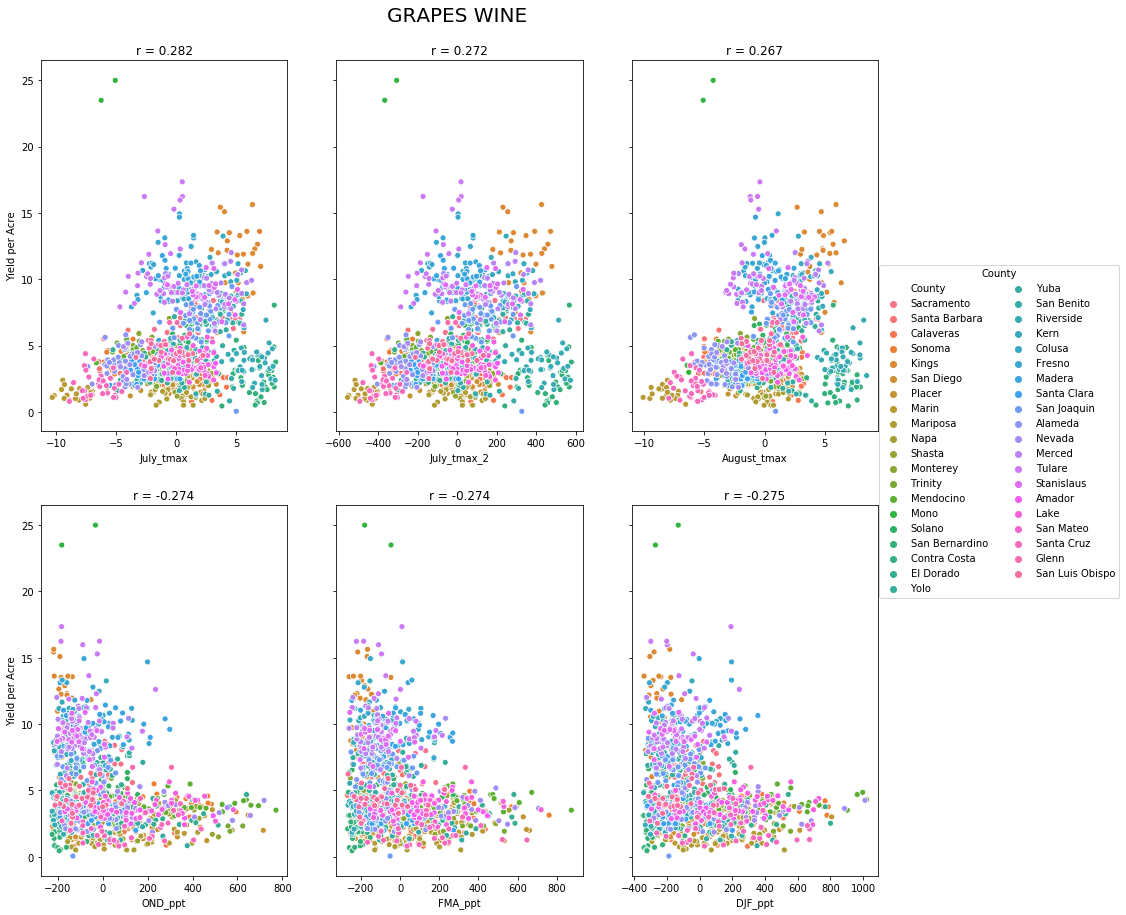

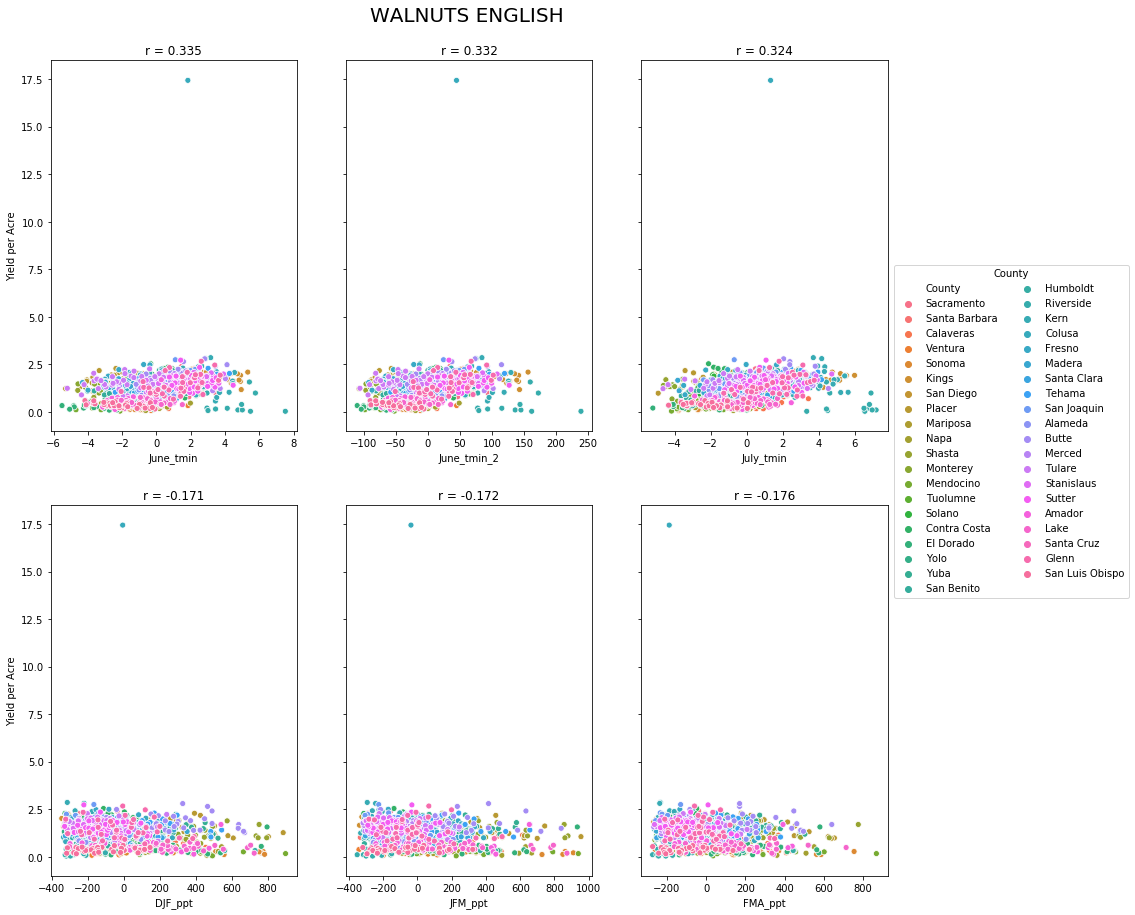

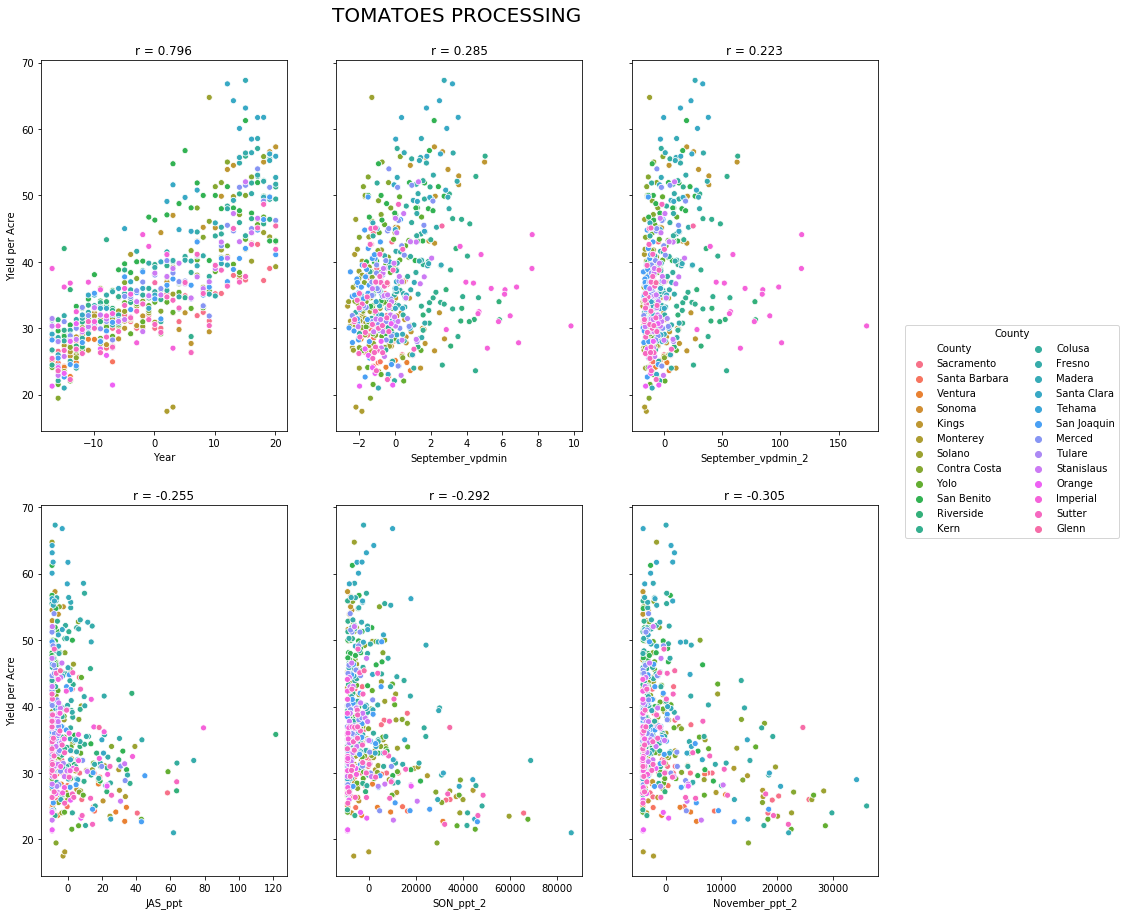

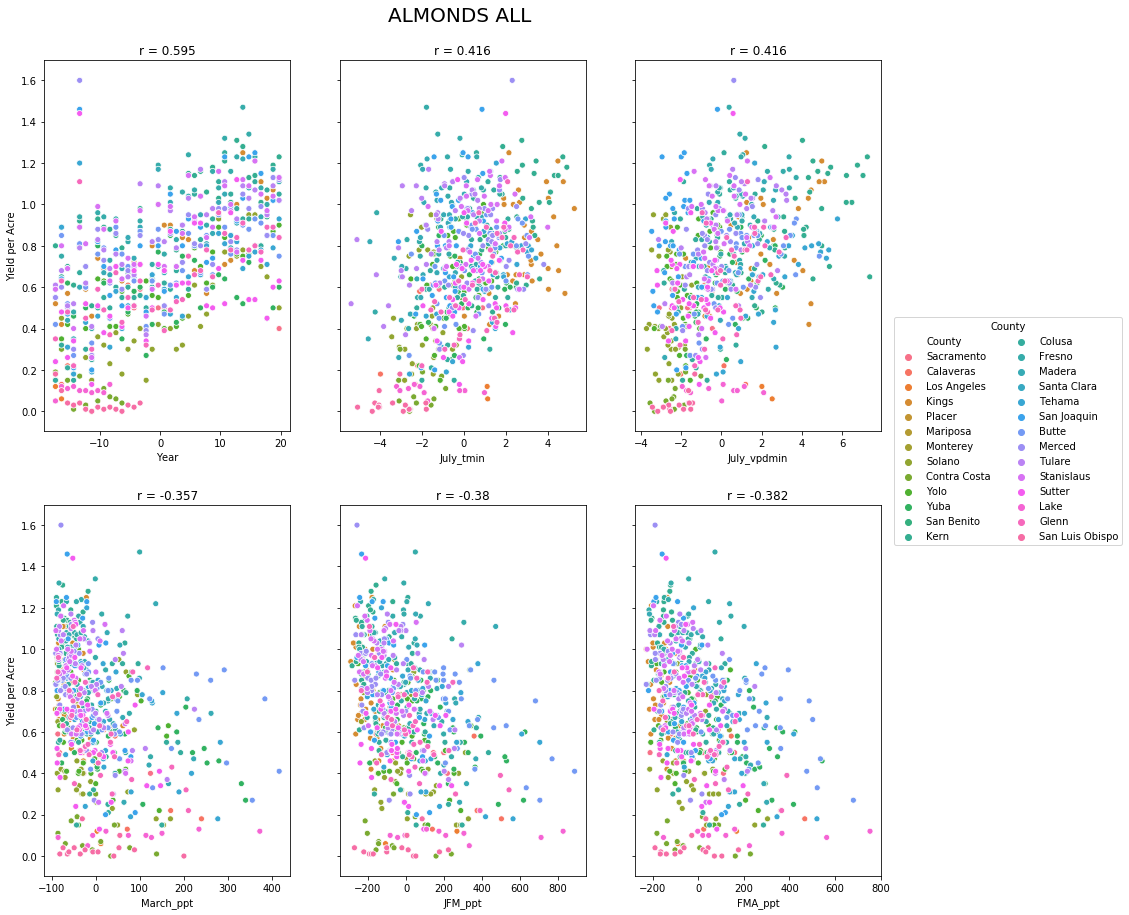

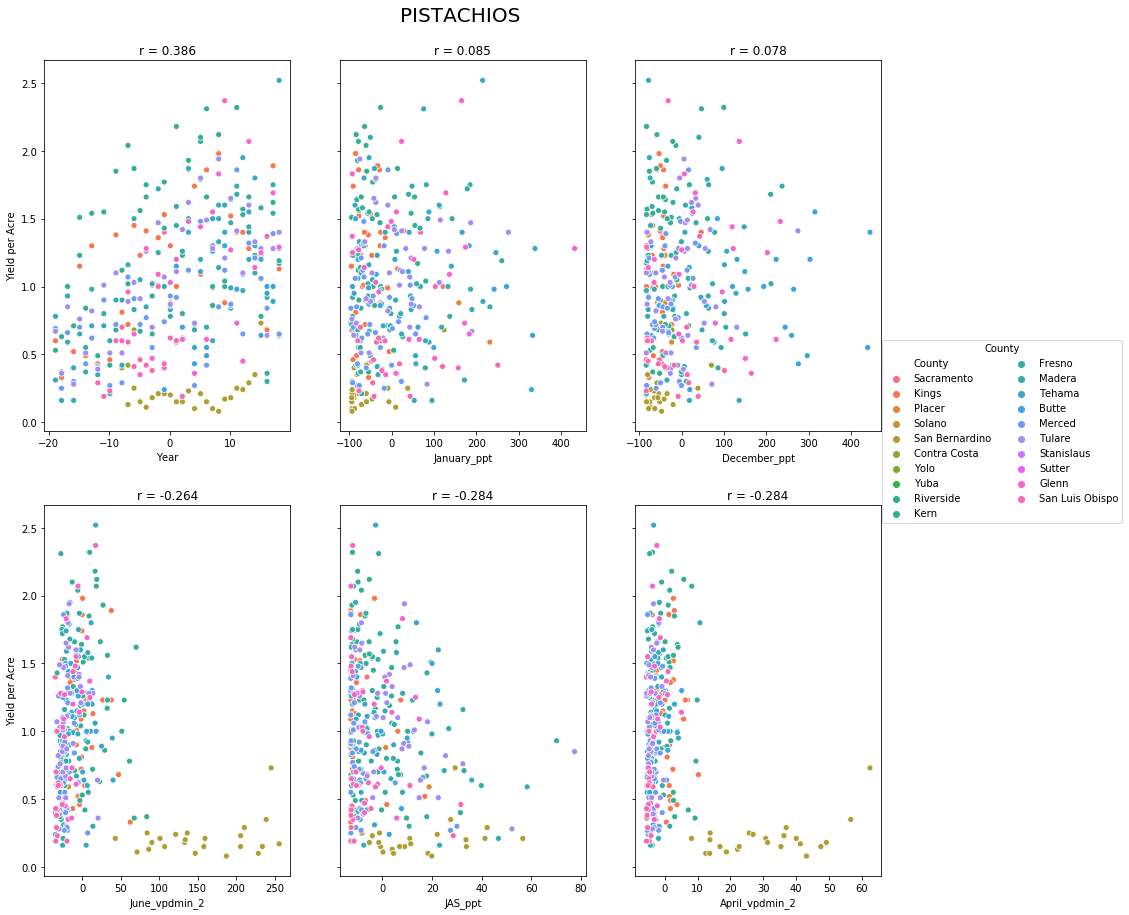

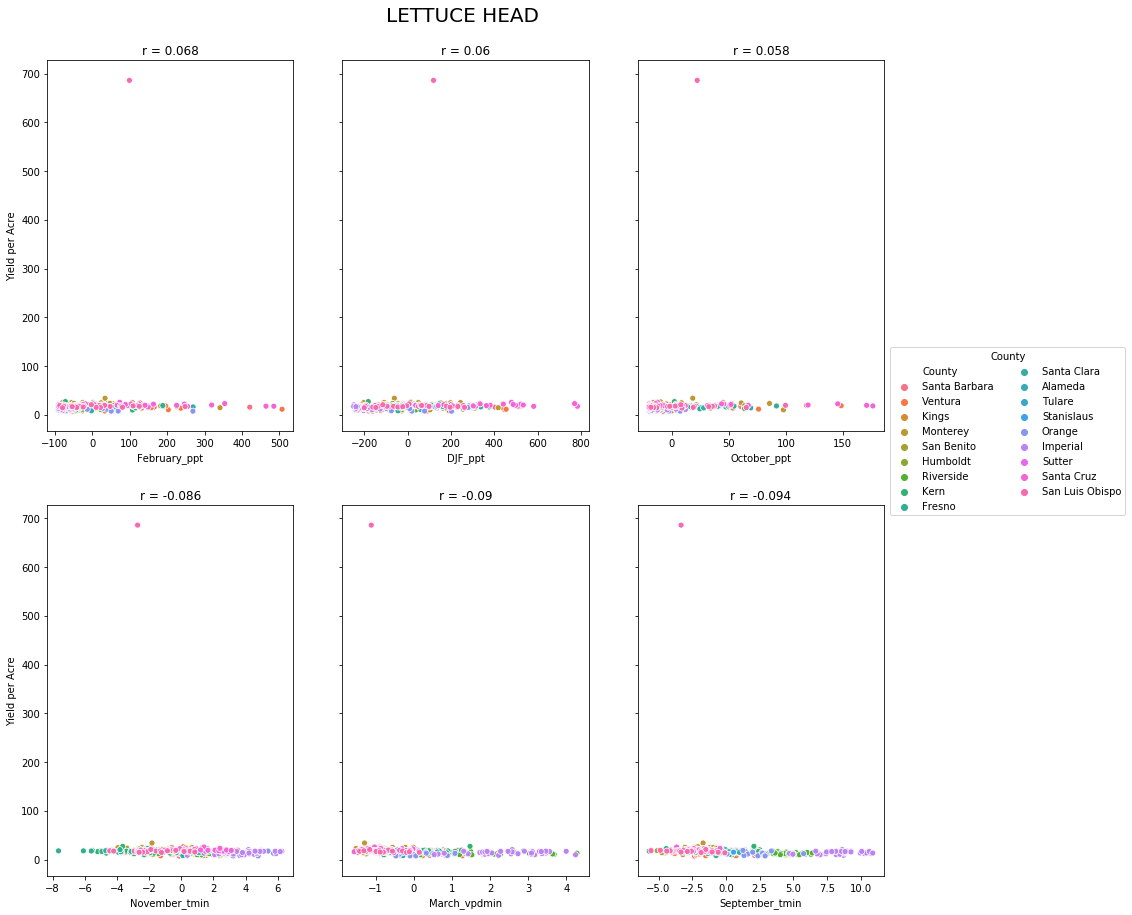

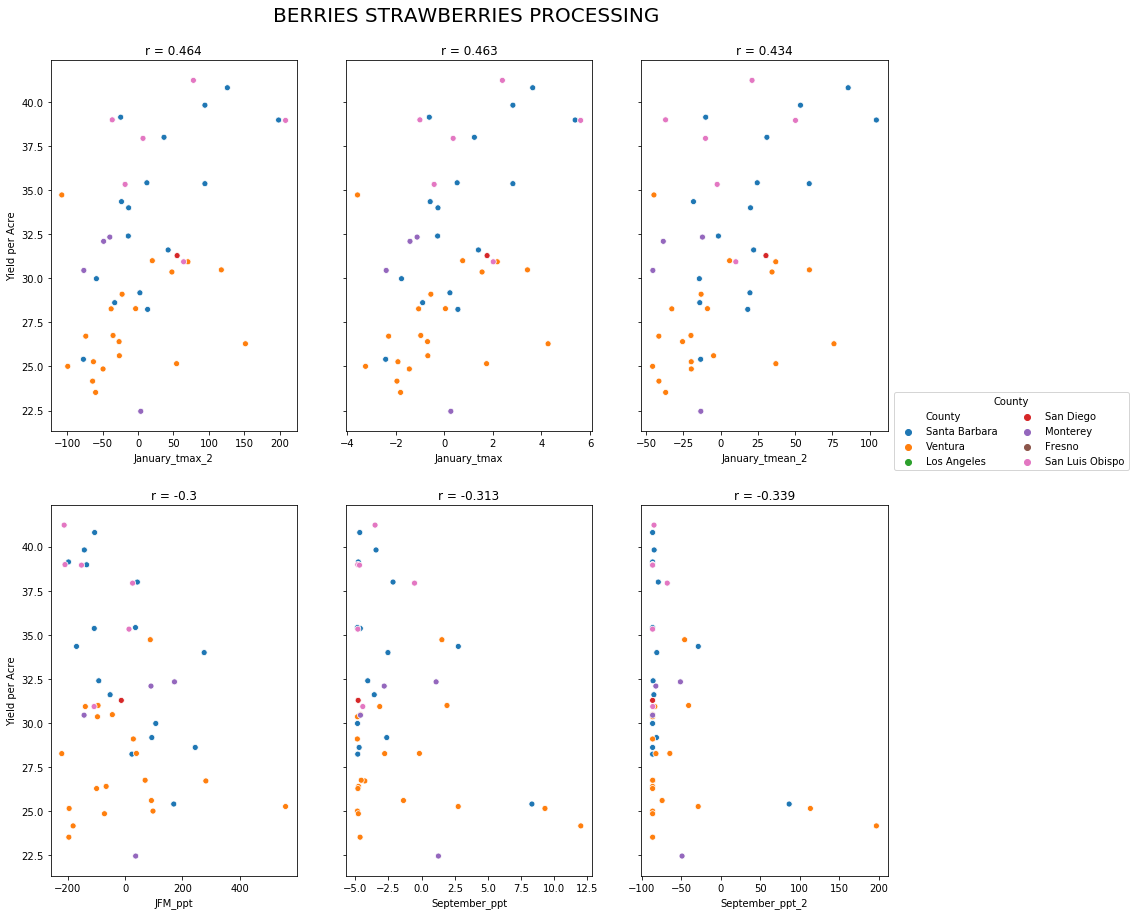

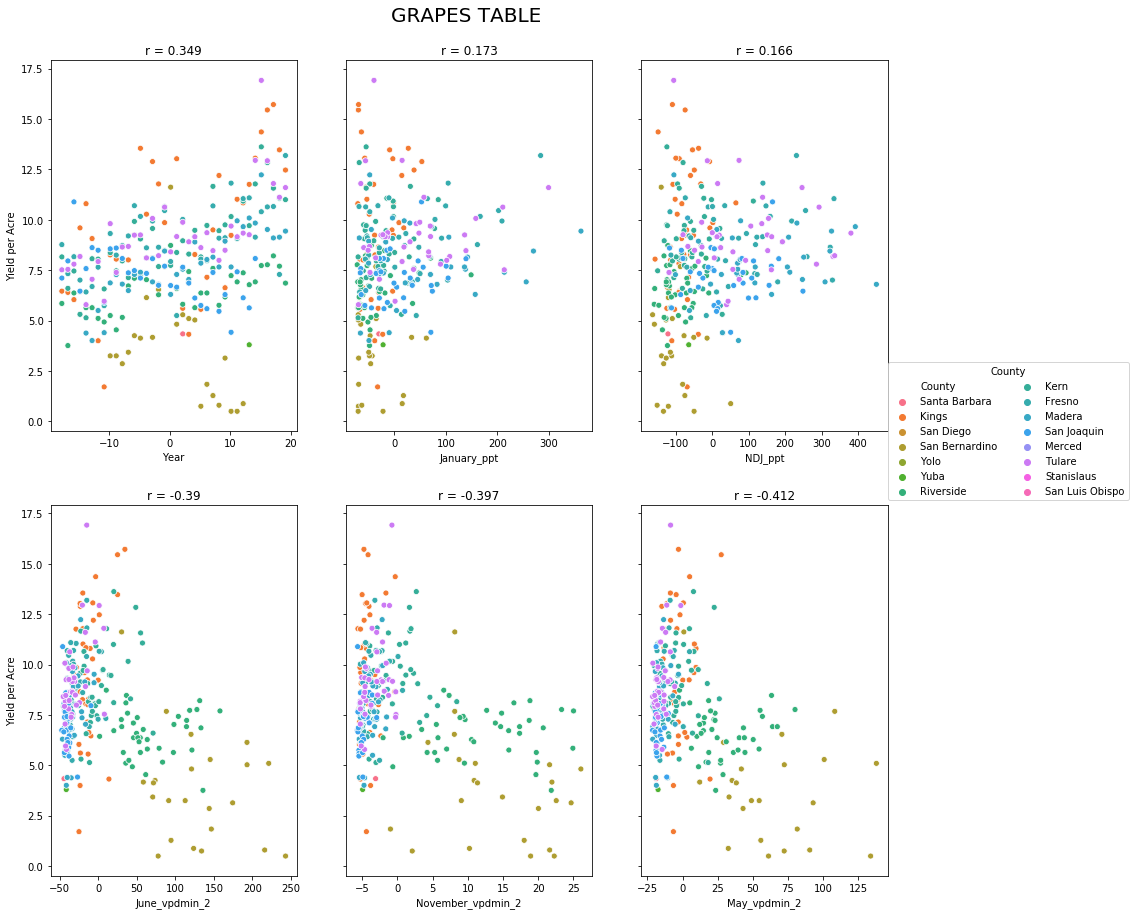

In [22]:
for crop in df_centered['Crop Name'].unique():
  
  #Filter to crop of interest
  df_crop = df_centered[df_centered['Crop Name'] == crop]
  
  #Drop unwanted columns
  df_crop = df_crop.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Production', 'Price per Unit', 'Total Value','Unit', 'Crop Name'], axis = 1)
  
  #Remove rows where nan values in target field
  df_crop = df_crop[pd.notnull(df_crop['Yield per Acre'])]
  
  #Find correlation between each predictor and target
  corrs = df_crop.drop('Yield per Acre', axis=1).apply(lambda x: x.corr(df_crop['Yield per Acre']))
  
  #Store correlations as a df, sort from greatest to least
  df_corr = corrs.sort_values(ascending = False).to_frame().reset_index().rename(columns = {'index':'Variable', 0:'Corr'})
  
  #Pick out top 3 and bottom 3
  df_vars = pd.concat([df_corr.head(3), df_corr.tail(3)])
  
  #Store variables as list
  vars = list(df_vars['Variable'].values)

  #Store correlations as list
  corr_values = list(df_vars['Corr'].values)
  
  #Plot scatter plots
  plot_matrix(vars, crop, corr_values)

**There are a few scatter plots where one outlier is obscuring the trend in the plot. We can plot those ones by hand.**

**WALNUTS ENGLISH**

(0, 3)

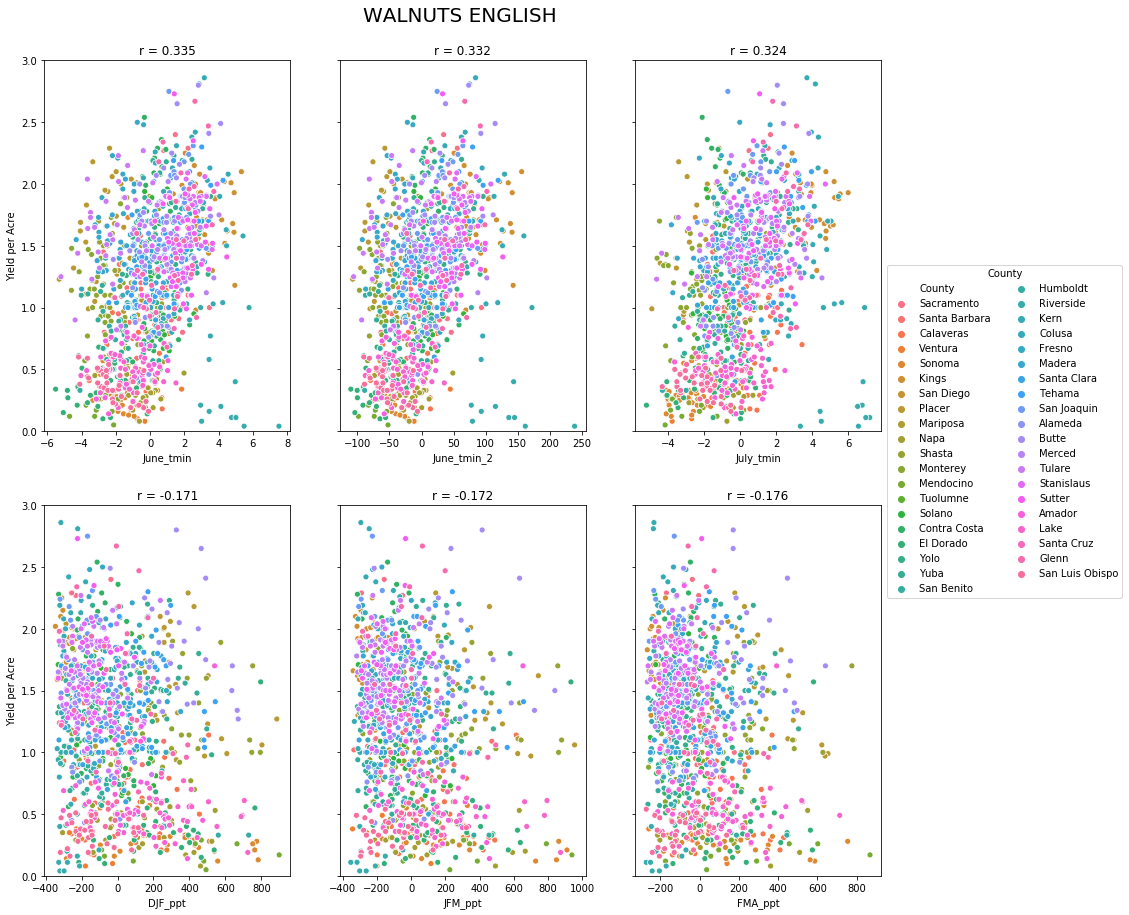

In [23]:
vars = ['June_tmin', 'June_tmin_2', 'July_tmin', 'DJF_ppt', 'JFM_ppt', 'FMA_ppt']
corr_values = [0.335, 0.332, 0.324, -0.171, -0.172, -0.176]

df_crop = df_centered[df_centered['Crop Name'] == 'WALNUTS ENGLISH']

fig, axes = plt.subplots(2, 3, figsize = (15,15), sharey = True)

sns.scatterplot(x = vars[0], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,0])
axes[0,0].set_title('r = ' + str(round(corr_values[0],3)))

sns.scatterplot(x = vars[1], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,1])
axes[0,1].set_title('r = ' + str(round(corr_values[1],3)))

sns.scatterplot(x = vars[2], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[0,2])
axes[0,2].set_title('r = ' + str(round(corr_values[2],3)))

sns.scatterplot(x = vars[3], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,0])
axes[1,0].set_title('r = ' + str(round(corr_values[3],3)))

sns.scatterplot(x = vars[4], y = 'Yield per Acre', hue = 'County', legend = False, data = df_crop, ax =axes[1,1])
axes[1,1].set_title('r = ' + str(round(corr_values[4],3)))

sns.scatterplot(x = vars[5], y = 'Yield per Acre', hue = 'County', data = df_crop, ax =axes[1,2])
axes[1,2].set_title('r = ' + str(round(corr_values[5],3)))

axes[1,2].legend(title = 'County', loc = 'center right', bbox_to_anchor = (2.0,1.2), ncol = 2)

plt.suptitle('WALNUTS ENGLISH', fontsize = 20, x = 0.51, y = 0.93)

plt.ylim(0,3)

# **Build Model**

https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn

https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/#four

http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html

https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

**At this point we need to drop columns that will not be part of the model. We also need to make sure that any NaNs are removed.**

In [0]:
#Let's do almonds only
df_almonds = df_centered_fixed[df_centered_fixed['Crop Name'] == 'ALMONDS ALL']

df_almond_model = df_almonds.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_almond_model = df_almond_model[pd.notnull(df_almond_model['Yield per Acre'])]

**We need to split our data in training and testing sets. We will use 30% of our data to test our model.**

In [25]:
from sklearn.model_selection import train_test_split
Y = df_almond_model['Yield per Acre']
X = df_almond_model.drop(['Yield per Acre'], axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False, stratify = None)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(461, 218) (461,)
(198, 218) (198,)


**Try playing around with alpha manually and see what happens.**

In [0]:
X_train.head(50)

In [27]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha = 4, max_iter =1e4)
model_lasso.fit(X_train, Y_train)
pred_train_lasso= model_lasso.predict(X_train)

from sklearn.metrics import r2_score
print(r2_score(Y_train, pred_train_lasso))

0.3783948702423465


In [28]:
#How many coefs are zero?
len(np.where(model_lasso.coef_ == 0)[0])

196

In [29]:
pred_test_lasso= model_lasso.predict(X_test)
print(r2_score(Y_test, pred_test_lasso))

0.2849304239517698


**Try finding alpha using CV**

In [30]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

lasso = Lasso(max_iter = 10000, normalize = False)

#No need to normalize! Already did that by subtracting mean!
lassocv = LassoCV(alphas = None, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train, Y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

Lasso(alpha=16.918443661974017, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
#R2 for train set
pred_train_lasso= lasso.predict(X_train)
print('Train', r2_score(Y_train, pred_train_lasso))

#R2 for test set
print('Test', r2_score(Y_test, lasso.predict(X_test)))

#MSE for train set
print('MSE train', mean_squared_error(Y_train, lasso.predict(X_train)))

#Huge MSE from test set
print('MSE test', mean_squared_error(Y_test, lasso.predict(X_test)))

Train 0.3065656906882753
Test 0.22720061725871532
MSE train 0.05664088485129055
MSE test 0.08146477979229491


In [32]:
lassocv.mse_path_.shape

(100, 5)

In [33]:
lassocv.alphas_.shape

(100,)

In [34]:
lassocv.mse_path_

array([[0.09930745, 0.088825  , 0.09413184, 0.0900837 , 0.06540233],
       [0.09870188, 0.08802097, 0.0940868 , 0.08912437, 0.06529823],
       [0.09816688, 0.08733806, 0.09285737, 0.08829861, 0.06371418],
       [0.09769383, 0.08675938, 0.09173138, 0.08758843, 0.06247095],
       [0.09727518, 0.08627033, 0.09069916, 0.08697824, 0.06151508],
       [0.09690433, 0.08585827, 0.08975209, 0.08645451, 0.06080069],
       [0.09657551, 0.08551227, 0.08888237, 0.08600551, 0.06028844],
       [0.09628366, 0.0852229 , 0.08808305, 0.08562106, 0.05994466],
       [0.09602437, 0.084982  , 0.08734784, 0.08529236, 0.05974053],
       [0.09579376, 0.08478254, 0.08667108, 0.08501175, 0.05965148],
       [0.09558844, 0.08461843, 0.08604768, 0.08477261, 0.05965656],
       [0.09540543, 0.08448444, 0.08547304, 0.08456922, 0.05973794],
       [0.09524213, 0.08437605, 0.08494298, 0.08439661, 0.05988049],
       [0.09509625, 0.08428939, 0.08445374, 0.08425047, 0.06007141],
       [0.09496578, 0.08422111, 0.

# Week 6 Model Work

Resources
https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

**We will start out only looking at almonds.**

**We will consider the dataset that has the fixed effects. Drop all non-essential columns such as county code, harvested acres, etc. Also critical to remove any NaN values.**

In [0]:
#Let's do almonds only
df_almonds = df_centered_fixed[df_centered_fixed['Crop Name'] == 'ALMONDS ALL']

#Drop non-essential columns
df_almond_model = df_almonds.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_almond_model = df_almond_model[pd.notnull(df_almond_model['Yield per Acre'])]

**Now we split the data into training and testing sets. We will NOT be shuffling the data.**

In [78]:
#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = df_almond_model['Yield per Acre']
X = df_almond_model.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False, stratify = None)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(461, 218) (461,)
(198, 218) (198,)


**We can use LassoCV to start us off in the right direction.**

In [79]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

MSE on train set: 0.05664088485129055
MSE on test set: 0.08146477979229491
R2 on train set: 0.3065656906882753
R2 on test set: 0.22720061725871532


**Look at the parameters of the value.**

In [81]:
lasso.get_params

<bound method BaseEstimator.get_params of Lasso(alpha=16.918443661974017, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)>

**It's great that LassoCV can find an alpha value for us, but it would be more informative to see how it is selecting this value.**

**The mse_path_ attribute shows use the mean square error for the test set on each fold, varying alpha. We can plot this against the alphas_ attribute which is all the alphas the model tried.**

Text(0, 0.5, 'Mean MSE for Each Iteration')

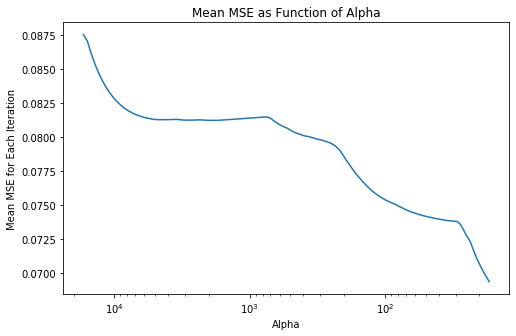

In [39]:
#Mean MSE for each iteration (5 folds per iteration)
mse = lassocv.mse_path_.mean(axis = 1)

#All the alphas
alphas = lassocv.alphas_

#Construct plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis and set a log scale
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('Mean MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

**Averaging the MSE for all the folds was not good idea. Better to see how each of the five folds performed.**

Text(0, 0.5, 'Mean MSE for Each Iteration')

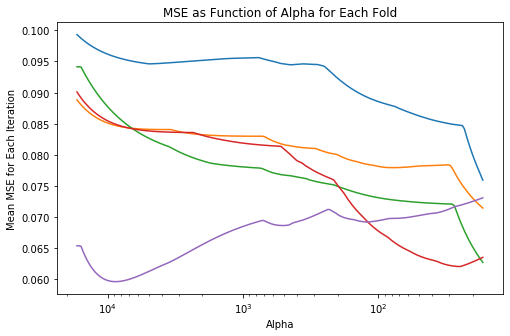

In [55]:
#Data
mse = lassocv.mse_path_
alphas = lassocv.alphas_

#Construct plot
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis and set a log scale
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('MSE as Function of Alpha for Each Fold')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

**The plot does not look like I expected it to look. Why does MSE drop off so suddenly when it gets close to zero? Doesn't this mean that multiple linear regression would yield simmilar results?**

**Can I reproduce this graph if I run the model myself?**

In [0]:
from sklearn import linear_model

#Number of alphas
n_alphas = 200

alphas =  np.logspace(-6, 6, n_alphas)

#MSE
MSE = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False, normalize = False)
    lasso.fit(X_train, Y_train)
    MSE.append(mean_squared_error(Y_train, lasso.predict(X_train)))

Text(0, 0.5, 'MSE')

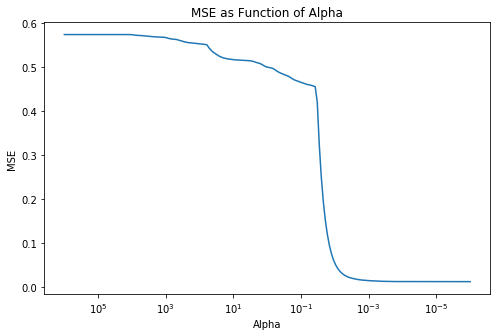

In [73]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,MSE)

#Reverse x axis
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')

In [0]:
from sklearn import linear_model

#Number of alphas
n_alphas = 200

alphas =  np.logspace(-10, 1, n_alphas)

#MSE
MSE = []
for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=False, normalize = False)
    lasso.fit(X_train, Y_train)
    MSE.append(mean_squared_error(Y_train, lasso.predict(X_train)))

Text(0, 0.5, 'MSE')

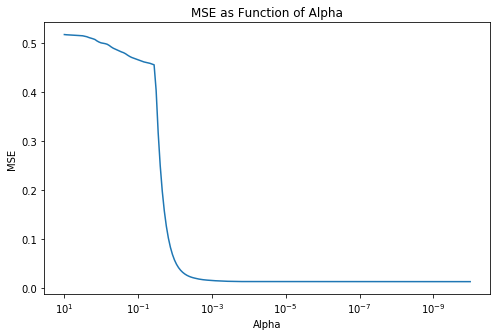

In [86]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,MSE)

#Reverse x axis
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('MSE')

**Ok so that looks pretty bad. Do other crops do this?**

In [42]:
#Let's do almonds only
df_walnut = df_centered_fixed[df_centered_fixed['Crop Name'] == 'WALNUTS ENGLISH']

#Drop non-essential columns
df_walnut_model = df_walnut.drop(['County','Commodity Code', 'County Code', 'Harvested Acres',
                 'Price per Unit', 'Total Value','Unit', 'Crop Name', 'Production'], axis = 1)

#Make sure all NaN values are removed
df_walnut_model = df_walnut_model[pd.notnull(df_walnut_model['Yield per Acre'])]

#Import package
from sklearn.model_selection import train_test_split

#Y is the target, X is the predictor
Y = df_walnut_model['Yield per Acre']
X = df_walnut_model.drop(['Yield per Acre'], axis = 1)

#30% test, 70% train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False, stratify = None)

#Make sure the data is the right shape
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(812, 218) (812,)
(349, 218) (349,)


In [43]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = None, n_alphas = 200, cv = 5, max_iter = 100000, normalize = False)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

MSE on train set: 0.5840468194014842
MSE on test set: 0.33954892547799354
R2 on train set: 0.0971352899442709
R2 on test set: 0.08075919147718846


Text(0, 0.5, 'Mean MSE for Each Iteration')

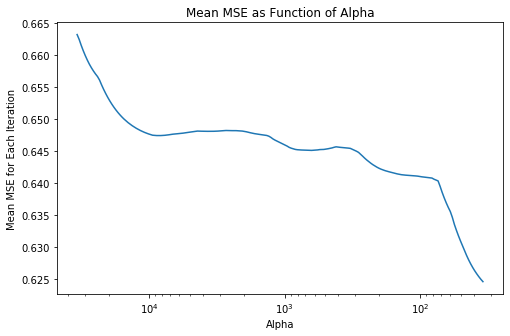

In [44]:
#Mean MSE for each iteration (5 folds per iteration)
mse = lassocv.mse_path_.mean(axis = 1)

alphas = lassocv.alphas_

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('Mean MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

#10,000 iterations, no normalization
lasso = Lasso(max_iter = 10000, normalize = False)

#Not specifying alphas to see what LassoCV comes up with
lassocv = LassoCV(alphas = np.linspace(1,0.00001).tolist(), cv = 5, normalize = False)
lassocv.fit(X_train, Y_train)

#Use lassoCV params in lasso model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)

print('MSE on train set:', mean_squared_error(Y_train, lasso.predict(X_train)))
print('MSE on test set:', mean_squared_error(Y_test, lasso.predict(X_test)))

print('R2 on train set:', r2_score(Y_train, lasso.predict(X_train)))
print('R2 on test set:', r2_score(Y_test, lasso.predict(X_test)))

Text(0, 0.5, 'Mean MSE for Each Iteration')

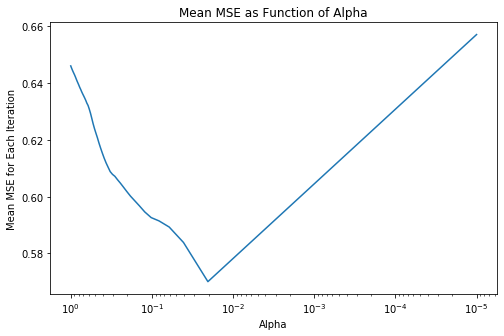

In [46]:
#Mean MSE for each iteration (5 folds per iteration)
mse = lassocv.mse_path_.mean(axis = 1)

alphas = lassocv.alphas_

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(alphas,mse)

#Reverse x axis
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])

#Format
plt.title('Mean MSE as Function of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE for Each Iteration')